In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle, math,datetime,pylab
from scipy.stats import skew, kurtosis
from scipy import stats,signal
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer,confusion_matrix
import scipy as sp
%matplotlib inline
from scipy.fftpack import fft, ifft

In [11]:
#Load raw time series data

d = pd.read_csv(r'C:\Users\Archana\Thesis\Data\04.10_Moment_C_W2_fokus_mit_Bohrende.csv')
d.drop(d.iloc[:, :2], inplace=True, axis=1)
h = pd.read_csv(r'C:\Users\Archana\Thesis\Data\04.10_Moment_C_W3_fokus.csv')
h.drop(h.iloc[:, :1], inplace=True, axis=1)

In [14]:
#function to calculate RMS value
def rmsValue(arr): 

      
    #Calculate square 
    sq= np.square(arr) 
      
    #Calculate Mean 
    mean_1 = np.mean(sq)
 
      
    #Calculate Root 
    root = np.sqrt(mean_1) 
      
    return root 

Text(0.5, 1.0, 'Frequency Domain')

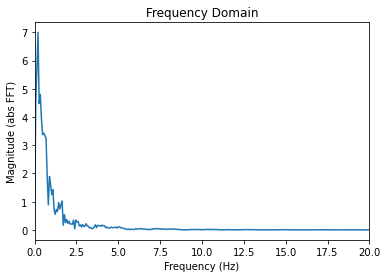

In [15]:
#fft

a=d
a= a[0:1]

start_time = 0 # seconds
end_time = len(a.T)/1000 # seconds
f_s = 1000 # Hz   Sampling frequency 
N = (end_time - start_time)*f_s 
T = 1/f_s # inverse of the sampling rate
x = np.linspace(0.0, 1.0/(2*T), int(N/2))


yt= a.to_numpy() #convert dataframe to array (input to fft in-built function should be array)
z = sp.signal.detrend(yt)

#fft algorithm

yr = fft(z) # "raw" FFT with both + and - frequencies
yre = yr.reshape(len(a.T), 1)
ft = 2/N * np.abs(yre[0:np.int(N/2)]) # positive freqs only

# Plotting the results
plt.xlim(0,20)
plt.plot(x,ft)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (abs FFT)')
plt.title('Frequency Domain')

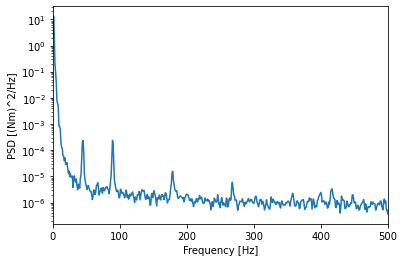

In [16]:
### Power spectral density using Welch method

f_den, Pxx_den = signal.welch(yt, f_s, window='hann',nperseg=1000,noverlap=256)
pxx = Pxx_den.reshape(len(f_den))
plt.semilogy(f_den, pxx)
plt.xlabel('Frequency [Hz]')
plt.xlim(0,500)
plt.ylabel('PSD [(Nm)^2/Hz]')
plt.show()

In [17]:
####Calculation of Power Spectral Density ----> Welch method W2_Spindle
### https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.welch.html


List_psd=[] #initialize an empty list

for j in range(len(d)): #loop iterates over all the rows of the raw data for 04. October
    
    b=d.iloc[j]
    bf = pd.DataFrame(b)
    c= bf.T
    yt= c.to_numpy() #convert dataframe to array (input to fft in-built function should be array)
    z = sp.signal.detrend(yt)
    fx_den, Pxx_den = signal.welch(yt, f_s, window='hann',nperseg=1000)
    pxx = Pxx_den.reshape(len(fx_den))
    
    
    psd_frame =pd.DataFrame(data =pxx, columns=[str(j)])   #creates dataframe of all fft + frequencies
    final_psd= psd_frame.T
    
    
    List_psd.append(final_psd) #append the list with dataframes of fft + frequencies


df_psd = pd.concat(List_psd) #concatenate all the dataframes in the list

In [18]:
t=d.T
k=h.T
############calculate time domain and non-domensional features for Spindle_W2##################

m = np.mean(t)  #mean
s = np.std(t)   #standard deviation
ku = sp.stats.kurtosis(t, fisher=True, bias=True ) #kurtosis
sk = sp.stats.skew(t, axis=0, bias=True) #skewness
median = np.median(t,axis=0) #median
mi = np.min(t) #minimum
ma = np.max(t) #maximum
rms = rmsValue(t) #call rmsValue function 
cf = ma/rms  #crest factor
sf = rms/abs(m)   #shape factor

#Creating Series by passing list of values

sk_new = pd.Series(sk)
sk_new = sk_new.iloc[0:]#.reset_index()
sk_new = sk_new.reset_index(drop=True)
ku_new = pd.Series(ku)
median_new = pd.Series(median)

In [ ]:
#Merge Spindle_W2 time-domain features
frames_T_W2 = [m, s, ku_new, sk_new, rms, cf, sf] 
merged_T_W2 = pd.concat(frames_T_W2, axis=1, keys=['Spindle_W2_mean', 'Spindle_W2_std', 'Spindle_W2_kurtosis', 'Spindle_W2_skew','Spindle_W2_RMS','Spindle_W2_CrestFactor','Spindle_W2_ShapeFactor'])
merged_T_W2 = merged_T_W2.reset_index(drop=True)

#Merge Spindle_W2 frequency-domain features
frames_F_W2 = [pkm, energy, mf, mbp, vbp, maxbp] 
merged_F_W2 = pd.concat(frames_F_W2, axis=1, keys=['Spindle_W2_PKM', 'Spindle_W2_Energy', 'Spindle_W2_MF', 'Spindle_W2_MBP','Spindle_W2_VBP','Spindle_W2_MaxBP'])


append1 = merged_T_W2.T.append(merged_F_W2.T)
append2 = append1.append(merged_F_W2.T)
merged_all= append5.T



merged_all.to_csv(r'C:/Users/Archana/Thesis/Data/Features/Merged_Features_Spindle_W2_and_W3_11.06.csv', index=False, sep=";")

In [ ]:
 ######Feature Selection Method Related with SVMs
    
x = pd.read_csv(r'C:\Users\Archana\Data\Features\Merged_Features_Spindle_W2_and_W3_all.csv', encoding = 'ISO-8859-1', sep=';')
y = pd.read_csv(r'C:\Users\Archana\Data\HPC\Qs Daten_04.10_18_19.02_11.06_Durchmesser und Konzentrizitaet_paarweise_vertauscht.csv', encoding = 'ISO-8859-1', sep=';')

x = x.T[0:29].T   ###All the features
X = x   
 ####Recursive elimination


from sklearn.feature_selection import RFE
from sklearn.svm import SVR

estimator = SVR(kernel="linear")
selector = RFE(estimator, 30, step=5)
selector = selector.fit(X, y)

In [36]:
b=selector.ranking_
c=pd.DataFrame(b,columns = ['Ranking'])
tr= c.T
feature = {'Features': ['Spindle_W2_mean', 'Spindle_W2_std', 'Spindle_W2_kurtosis', 'Spindle_W2_skew',
                        'Spindle_W2_RMS','Spindle_W2_CrestFactor','Spindle_W2_ShapeFactor',
                        'Spindle_W2_PKM', 'Spindle_W2_Energy', 'Spindle_W2_MF', 'Spindle_W2_MBP','Spindle_W2_VBP',
                        'Spindle_W2_MaxBP', 'Spindle_W2_KUBP','Spindle_W2_SKBP',
                        'Spindle_W3_mean', 'Spindle_W3_std', 'Spindle_W3_kurtosis', 'Spindle_W3_skew',
                        'Spindle_W3_RMS','Spindle_W3_CrestFactor','Spindle_W3_ShapeFactor','Spindle_W3_PKM', 
                        'Spindle_W3_Energy', 'Spindle_W3_MF', 'Spindle_W3_MBP','Spindle_W3_VBP','Spindle_W3_MaxBP',
                       'Spindle_W3_KUBP','Spindle_W3_SKBP']}

df = pd.DataFrame(feature, columns = ['Features'])
rank=pd.concat([df.T,tr],ignore_index=False)
features_s= rank.T
features_s

,Features,Ranking
0,Spindle_W2_mean,1
1,Spindle_W2_std,1
2,Spindle_W2_kurtosis,1
3,Spindle_W2_skew,1
4,Spindle_W2_RMS,1
5,Spindle_W2_CrestFactor,1
6,Spindle_W2_ShapeFactor,1
7,Spindle_W2_PKM,1
8,Spindle_W2_Energy,1
9,Spindle_W2_MF,1


In [37]:
####Selecting/grouping all the features with rank 1

rslt_df = features_s[(features_s['Ranking'] == 1)] 
rslt_df         

,Features,Ranking
0,Spindle_W2_mean,1
1,Spindle_W2_std,1
2,Spindle_W2_kurtosis,1
3,Spindle_W2_skew,1
4,Spindle_W2_RMS,1
5,Spindle_W2_CrestFactor,1
6,Spindle_W2_ShapeFactor,1
7,Spindle_W2_PKM,1
8,Spindle_W2_Energy,1
9,Spindle_W2_MF,1
